# gdgtm regression test

The goal of this test is to evaluate whether the gdgtm (**g**eospatial **d**ata **g**etting, **t**ransforming, **m**anaging) pipeline built to feed standardized rasters for downstream ML actions (overall goal of the gdgtm package) is working as intended. The test script is structured as follows:

- Section 1: Test the flow of the relevant "get" functions
- Section 2: Test the core pipeline for creating the "master" raster
- Section 3: Test the mosaics and raster combination components
- Section 4: Test the alignment and validation line
- Section 5: STAC get functions
- Section 6: Shapefile conversion
- Section 7: Numpyifying rasters

This is the test script and not intended as primarz documentation ' for that, please refer to the "documentation" folder and the demo.

Current tested version: **0.5.5**

In [8]:
import gdgtm
import rasterio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import re

## Test preparation
This section sets up the directory structure for the test script. This ensures the removal of any old test material, clearing any old structures and putting in new ones.

In [2]:
## Set up the test directory urls
test_location = "/home/pete/Documents/tests_and_vals/" ## Change to local spec
test_directory = "gdgtm_test"

test_path = test_location + test_directory
subdir_names = ["01_get_functions", "02_master_reprojected", 
                "03_master_rescaled", "04_master_rebound", 
                "05_complimentary_aligned", "06_mosaic_merge_prep", 
                "07_mosaic_merge_out", "08_bound_shapefiles",
                "09_rasters_from_shp", "10_rasters_from_numpy"]

In [3]:
### Function for deleting directory contents

def delete_dir_contents (directory):
    files = os.listdir(directory)
    for file in files:
        filepath = os.path.join(directory + "/", file)
        os.remove(filepath)

    return print(os.listdir(directory))


In [4]:
## Run the deletions
for name in subdir_names:
    subdir_path = test_path + "/" + name
    if os.path.exists(subdir_path):
        items_in_subdir = len(os.listdir(subdir_path))
        if items_in_subdir > 0:
            delete_dir_contents(subdir_path)
            print(f"Deleted {items_in_subdir} from the sub-directory {name}")
        else:
            print(f"Sub-directory {name} is empty")
        os.rmdir(subdir_path)
        print(f"Deleted {subdir_path}")

os.rmdir(test_path)

Sub-directory 01_get_functions is empty
Deleted /home/pete/Documents/tests_and_vals/gdgtm_test/01_get_functions
Sub-directory 02_master_reprojected is empty
Deleted /home/pete/Documents/tests_and_vals/gdgtm_test/02_master_reprojected
Sub-directory 03_master_rescaled is empty
Deleted /home/pete/Documents/tests_and_vals/gdgtm_test/03_master_rescaled
Sub-directory 04_master_rebound is empty
Deleted /home/pete/Documents/tests_and_vals/gdgtm_test/04_master_rebound
Sub-directory 05_complimentary_aligned is empty
Deleted /home/pete/Documents/tests_and_vals/gdgtm_test/05_complimentary_aligned
Sub-directory 06_mosaic_merge_prep is empty
Deleted /home/pete/Documents/tests_and_vals/gdgtm_test/06_mosaic_merge_prep
Sub-directory 07_mosaic_merge_out is empty
Deleted /home/pete/Documents/tests_and_vals/gdgtm_test/07_mosaic_merge_out
Sub-directory 08_bound_shapefiles is empty
Deleted /home/pete/Documents/tests_and_vals/gdgtm_test/08_bound_shapefiles
Sub-directory 09_rasters_from_shp is empty
Deleted /

In [5]:
## Re-build the test location structure

os.mkdir(test_path)

for name in subdir_names:
    os.mkdir(test_path + "/" + name)

## Section 1: "get" function tests

In [3]:
## Section 1 subdir_path
get_functions_subdir = test_path + "/" + subdir_names[0] + "/"

In [4]:
print(get_functions_subdir)

/home/pete/Documents/tests_and_vals/gdgtm_test/01_get_functions/


### get_chelsa_daily

File exists: /home/pete/Documents/tests_and_vals/gdgtm_test/01_get_functions/chelsa_tas_01_01_2023.tif
File exists: /home/pete/Documents/tests_and_vals/gdgtm_test/01_get_functions/chelsa_tas_02_01_2023.tif
File exists: /home/pete/Documents/tests_and_vals/gdgtm_test/01_get_functions/chelsa_tas_03_01_2023.tif
File exists: /home/pete/Documents/tests_and_vals/gdgtm_test/01_get_functions/chelsa_tas_04_01_2023.tif
File exists: /home/pete/Documents/tests_and_vals/gdgtm_test/01_get_functions/chelsa_tas_05_01_2023.tif


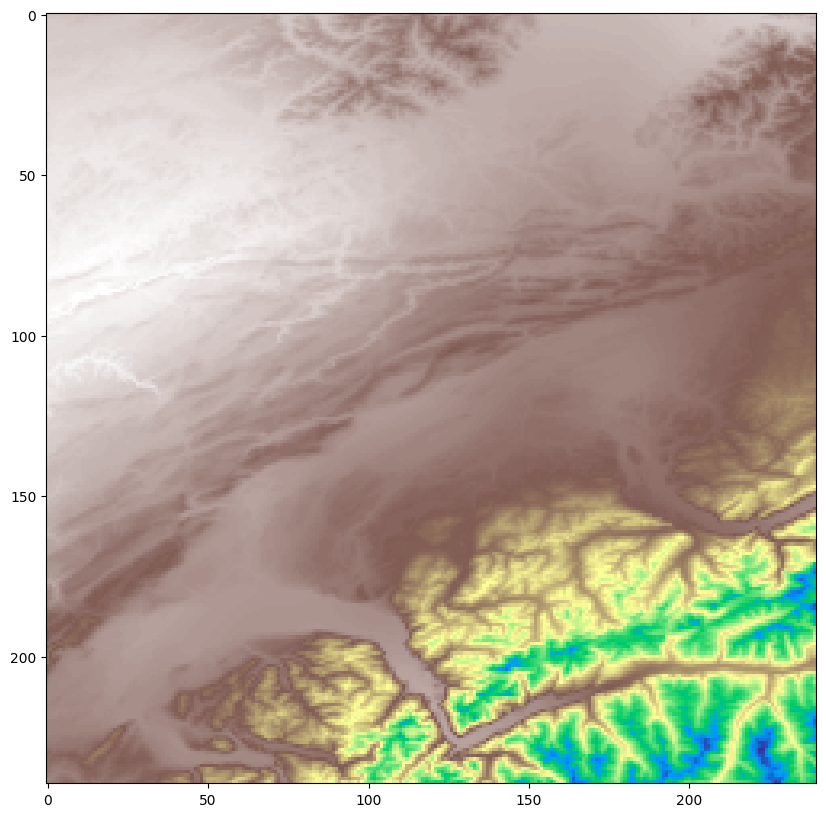

In [7]:
### get_chelsa_daily (1): happy path, tas parameter

try:
    test_1 = gdgtm.get_chelsa_daily(parameter = "tas", bbox = (6.0, 48.0, 8.0, 46.0), 
                                    interval = ("2023-1-1", "2023-1-5"), dst_path = get_functions_subdir,
                                    dst_name = "chelsa_tas_"
                                   )

    for item in test_1:
        print(item)
except Exception as e:
    print(f"Function failed to generate output: {e}")


## Expected outcome: strings indicating target .tiff exists and sample raster printed
try:
    with rasterio.open(get_functions_subdir + "chelsa_tas_01_01_2023.tif") as target:
        target_data = target.read(masked = True)
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain') # For single-band raster
        plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not exist: {e}")

## Expectation: file exists and map generates


#### Test outcome

Results meet expectation

In [9]:
### get_chelsa_daily (2): happy path, pr parameter

try:
    test_1 = gdgtm.get_chelsa_daily(parameter = "pr", bbox = (-75.0, -5.0, -70.0, -10.0), 
                                    interval = ("1990-6-11", "1990-6-15"), dst_path = get_functions_subdir,
                                    dst_name = "chelsa_pr_"
                                   )

    for item in test_1:
        print(item)
        
except Exception as e:
    print(f"Function failed to generate output: {e}")


## Expected outcome: strings indicating target .tiff exists and sample raster printed
try:
    with rasterio.open(get_functions_subdir + "chelsa_pr_11_06_1990.tif") as target:
        target_data = target.read(masked = True)
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain') # For single-band raster
        plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not exist: {e}")

    
## Expectation: file exists and map generates

Function failed to generate output: Received a NULL pointer.
Could not plot raster, or raster does not exist: /home/pete/Documents/tests_and_vals/gdgtm_test/01_get_functions/chelsa_pr_11_06_1990.tif: No such file or directory


ERROR 1: An error occurred while creating a virtual connection to the DAP server:Error while reading the URL: https://os.unil.cloud.switch.ch/chelsa02/chelsa/global/daily/pr/1990/CHELSA_pr_11_06_1990_V.2.1.tif.ver.
The OPeNDAP server returned the following message:
Not Found: The data source or server could not be found.
        Often this means that the OPeNDAP server is missing or needs attention.
        Please contact the server administrator.
ERROR 1: Driver DODS is considered for removal in GDAL 3.5. You are invited to convert any dataset in that format to another more common one. If you need this driver in future GDAL versions, create a ticket at https://github.com/OSGeo/gdal (look first for an existing one first) to explain how critical it is for you (but the GDAL project may still remove it), and to enable it now, set the GDAL_ENABLE_DEPRECATED_DRIVER_DODS configuration option / environment variable to YES.


#### Test outcome

Results meet expectation

In [10]:
### get_chelsa_daily (3): wrong dates
try: 
    test_1 = gdgtm.get_chelsa_daily(parameter = "pr", 
                                    bbox = (-75.0, -5.0, -70.0, -10.0), 
                                    interval = ("1700-6-11", "1700-6-15"), 
                                    dst_path = get_functions_subdi,
                                    dst_name = "chelsa_pr_"
                                   )

    for item in test_1:
        print(item)
except Exception as e:
    print(f"Function failed to generate output: {e}")

## Expectation: error


Function failed to generate output: name 'get_functions_subdi' is not defined


#### Test outcome

Results meet expectation


### get_chelsa_bio_19812010_data
Note: for current round of tests testing only for use in line with assumptions, in particular using correct Chelsa filenames.

In [11]:
extent = (5.7663, 47.9163, 10.5532, 45.6755)

try:
    gdgtm.get_chelsa_bio_19812010_data("gsp", bbox = extent, dst_raster = get_functions_subdir + "chelsa_bio_gsp.tif")
except Exception as e:
    print(f"Function failed to generate output: {e}")  

try:
    with rasterio.open(get_functions_subdir + "chelsa_bio_gsp.tif") as target:
        target_data = target.read(masked = True)
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain') # For single-band raster
        plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not exist: {e}")

## Expectation: file exists and map generates

Function failed to generate output: Received a NULL pointer.
Could not plot raster, or raster does not exist: /home/pete/Documents/tests_and_vals/gdgtm_test/01_get_functions/chelsa_bio_gsp.tif: No such file or directory


ERROR 1: An error occurred while creating a virtual connection to the DAP server:Error while reading the URL: https://os.zhdk.cloud.switch.ch/envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_gsp_1981-2010_V.2.1.tif.ver.
The OPeNDAP server returned the following message:
Not Found: The data source or server could not be found.
        Often this means that the OPeNDAP server is missing or needs attention.
        Please contact the server administrator.
ERROR 1: Driver DODS is considered for removal in GDAL 3.5. You are invited to convert any dataset in that format to another more common one. If you need this driver in future GDAL versions, create a ticket at https://github.com/OSGeo/gdal (look first for an existing one first) to explain how critical it is for you (but the GDAL project may still remove it), and to enable it now, set the GDAL_ENABLE_DEPRECATED_DRIVER_DODS configuration option / environment variable to YES.


#### Test outcome:
Results meet expectation


In [12]:
extent = (-1.0, 0, 50, -47.6755)

try:
    gdgtm.get_chelsa_bio_19812010_data("kg0", bbox = extent, dst_raster = get_functions_subdir + "chelsa_bio_kg0_raw.tif")
except Exception as e:
    print(f"Function failed to generate output: {e}")       

try:
    with rasterio.open(get_functions_subdir + "chelsa_bio_kg0_raw.tif") as target:
        target_data = target.read(masked = True)
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain') # For single-band raster
        # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
        plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not exist: {e}")


## Expectation: file exists and map generates

Function failed to generate output: Received a NULL pointer.
Could not plot raster, or raster does not exist: /home/pete/Documents/tests_and_vals/gdgtm_test/01_get_functions/chelsa_bio_kg0_raw.tif: No such file or directory


ERROR 1: An error occurred while creating a virtual connection to the DAP server:Error while reading the URL: https://os.zhdk.cloud.switch.ch/envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/CHELSA_kg0_1981-2010_V.2.1.tif.ver.
The OPeNDAP server returned the following message:
Not Found: The data source or server could not be found.
        Often this means that the OPeNDAP server is missing or needs attention.
        Please contact the server administrator.
ERROR 1: Driver DODS is considered for removal in GDAL 3.5. You are invited to convert any dataset in that format to another more common one. If you need this driver in future GDAL versions, create a ticket at https://github.com/OSGeo/gdal (look first for an existing one first) to explain how critical it is for you (but the GDAL project may still remove it), and to enable it now, set the GDAL_ENABLE_DEPRECATED_DRIVER_DODS configuration option / environment variable to YES.


#### Test outcome: 
Results meet expectation



### get_chelsa_clim_19812010_data
Note: for current round of tests testing only for use in line with assumptions, in particular using correct Chelsa filenames.

In [13]:
extent = (-5.7663, -45.9163, 0.5532, -47.6755)

try:
    gdgtm.get_chelsa_clim_19812010_data("tas", "06", bbox = extent, dst_raster = get_functions_subdir + "chelsa_clim_pr_jun_raw.tif")
except Exception as e:
    print(f"Function failed to generate output: {e}")
    
try:
    with rasterio.open(get_functions_subdir + "chelsa_clim_pr_jun_raw.tif") as target:
        target_data = target.read(masked = True)
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain') # For single-band raster
        plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not exist: {e}")

## Expectation: file exists and map generates

Function failed to generate output: Received a NULL pointer.
Could not plot raster, or raster does not exist: /home/pete/Documents/tests_and_vals/gdgtm_test/01_get_functions/chelsa_clim_pr_jun_raw.tif: No such file or directory


ERROR 1: An error occurred while creating a virtual connection to the DAP server:Error while reading the URL: https://os.zhdk.cloud.switch.ch/envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/tas/CHELSA_tas_06_1981-2010_V.2.1.tif.ver.
The OPeNDAP server returned the following message:
Not Found: The data source or server could not be found.
        Often this means that the OPeNDAP server is missing or needs attention.
        Please contact the server administrator.
ERROR 1: Driver DODS is considered for removal in GDAL 3.5. You are invited to convert any dataset in that format to another more common one. If you need this driver in future GDAL versions, create a ticket at https://github.com/OSGeo/gdal (look first for an existing one first) to explain how critical it is for you (but the GDAL project may still remove it), and to enable it now, set the GDAL_ENABLE_DEPRECATED_DRIVER_DODS configuration option / environment variable to YES.


#### Test outcome:
Results meet expectation, but the **Warning 1** will need to be addressed downstream.



In [14]:
extent = (5.7663, 47.9163, 10.5532, 45.6755)

try:
    gdgtm.get_chelsa_clim_19812010_data("sfcWind", "01", bbox = extent, dst_raster = get_functions_subdir + "chelsa_clim_sfcWind_jan_raw.tif")
except Exception as e:
    print(f"Function failed to generate output: {e}")

try:
    with rasterio.open(get_functions_subdir + "chelsa_clim_sfcWind_jan_raw.tif") as target:
        target_data = target.read(masked = True)
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain')
        plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not exist: {e}")

## Expectation: file exists and map generates

Function failed to generate output: Received a NULL pointer.
Could not plot raster, or raster does not exist: /home/pete/Documents/tests_and_vals/gdgtm_test/01_get_functions/chelsa_clim_sfcWind_jan_raw.tif: No such file or directory


ERROR 1: An error occurred while creating a virtual connection to the DAP server:Error while reading the URL: https://os.zhdk.cloud.switch.ch/envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/sfcWind/CHELSA_sfcWind_01_1981-2010_V.2.1.tif.ver.
The OPeNDAP server returned the following message:
Not Found: The data source or server could not be found.
        Often this means that the OPeNDAP server is missing or needs attention.
        Please contact the server administrator.
ERROR 1: Driver DODS is considered for removal in GDAL 3.5. You are invited to convert any dataset in that format to another more common one. If you need this driver in future GDAL versions, create a ticket at https://github.com/OSGeo/gdal (look first for an existing one first) to explain how critical it is for you (but the GDAL project may still remove it), and to enable it now, set the GDAL_ENABLE_DEPRECATED_DRIVER_DODS configuration option / environment variable to YES.


#### Test outcome:

Results meet expectation



### get_cognames_from_stac_coll_static

In [15]:
### get_cognames_from_stac_coll_static (1): correct url for an OLM collection value

try:
    test = gdgtm.get_cognames_static_stac("https://s3.eu-central-1.wasabisys.com/stac/openlandmap/wilderness_li2022.human.footprint/collection.json")
    print(test[0])
except Exception as e:
    print(f"Function failed to generate output: {e}")

## Expected outcome: url to a geotiff

https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20000101_20001231_go_epsg.4326_v16022022.tif


#### Test outcome

Results meet expectation

In [ ]:
### get_cognames_from_stac_coll_static (2): correct url for a Capella collection value

try:
    test = gdgtm.get_cognames_static_stac("https://capella-open-data.s3.us-west-2.amazonaws.com/stac/capella-open-data-by-instrument-mode/capella-open-data-stripmap/collection.json")
    print(test[0])
except Exception as e:
    print(f"Function failed to generate output: {e}")
## Expected outcome: url to a geotiff

#### Test outcome

Results meet expectation

In [ ]:
### get_cognames_from_stac_coll_static (3): wrong url provided
try:
    test = gdgtm.get_cognames_static_stac("https://www.unifr.ch/theo/fr/")
    print(test[0])
except Exception as e:
    print(f"Function failed to generate output: {e}")  

## Expected outcome: an error message

#### Test outcome

Results meet expectation

### get_olm_cogs

In [10]:
### get_olm_cogs (1): correct url for an OLM collection value - Human footprint

bbox = (5.7663, 47.9163, 10.5532, 45.6755) ##WNES bbox

try:
    test = gdgtm.get_cognames_static_stac("https://s3.eu-central-1.wasabisys.com/stac/openlandmap/wilderness_li2022.human.footprint/collection.json")
    gdgtm.get_olm_cogs(cognames = test, 
                       target_directory = get_functions_subdir, 
                       target_names = "olm_humfoot_switz_raw_",
                       bbox = bbox,
                       interval = ("20000601", "20050101")
                      )
except Exception as e:
    print(f"Function failed to generate output: {e}")  

## Expected outcome: a list of four downloaded files

Function failed to generate output: Received a NULL pointer.


ERROR 1: An error occurred while creating a virtual connection to the DAP server:Error while reading the URL: https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20010101_20011231_go_epsg.4326_v16022022.tif.ver.
The OPeNDAP server returned the following message:
Not Found: The data source or server could not be found.
        Often this means that the OPeNDAP server is missing or needs attention.
        Please contact the server administrator.
ERROR 1: Driver DODS is considered for removal in GDAL 3.5. You are invited to convert any dataset in that format to another more common one. If you need this driver in future GDAL versions, create a ticket at https://github.com/OSGeo/gdal (look first for an existing one first) to explain how critical it is for you (but the GDAL project may still remove it), and to enable it now, set the GDAL_ENABLE_DEPRECATED_DRIVER_DODS configuration option / environment variable to YES.


#### Test outcome

Results meet expectation

In [ ]:
### get_olm_cogs (2): correct url for an OLM collection value - ESA CCI annual land cover

bbox = (5.7663, 47.9163, 10.5532, 45.6755) ##WNES bbox

try:
    test = gdgtm.get_cognames_static_stac("https://s3.eu-central-1.wasabisys.com/stac/openlandmap/land.cover_esacci.lc.l4/collection.json")
    gdgtm.get_olm_cogs(cognames = test, 
                       target_directory = get_functions_subdir, 
                       target_names = "olm_alc_switz_raw_",
                       bbox = bbox,
                       interval = ("20000601", "20050101")
                      )
except Exception as e:
    print(f"Function failed to generate output: {e}")

## Expected outcome: a list of four downloaded files

#### Test outcome

Results meet expectation, but the underpinning function needs re-written to better run the file exists check

In [ ]:
### get_olm_cogs (3): test defaults

try:
    test = gdgtm.get_cognames_static_stac("https://s3.eu-central-1.wasabisys.com/stac/openlandmap/ph.h2o_usda.4c1a2a/collection.json")
    gdgtm.get_olm_cogs(cognames = test[0], 
                       target_directory = get_functions_subdir, 
                       target_names = "olm_soilph_eurafr_raw_"
                      )
except Exception as e:
    print(f"Function failed to generate output: {e}")
    
## Expected outcome: a list of one downloaded file

#### Test outcome

Results do not meet expectations.
Diagnostic: inability to handle files without timestamps in names

## Section 2: creating the "Master" geotiff

In [ ]:
### Create the directories
reproject_subdir = test_path + "/" + subdir_names[1] + "/"
rescale_subdir = test_path + "/" + subdir_names[2] + "/"
rebound_subdir = test_path + "/" + subdir_names[3] + "/"

print(reproject_subdir)
print(rescale_subdir)
print(rebound_subdir)


### reproject_raster

In [ ]:
### reproject_raster (1): error - provide faulty new_crs

try:
    gdgtm.reproject_raster(new_crs = "ggplot:2", 
                           src_raster = get_functions_subdir + "chelsa_tas_01_01_2023.tif",
                           dst_raster = reproject_subdir + "chelsa_pr_reprojected_error.tif",
                           delete_source = True)
except Exception as e:
    print(f"Function failed to generate output: {e}")

print("Source file retained: " + str(os.path.exists(get_functions_subdir + "chelsa_tas_01_01_2023.tif")))
## Expected outcome: Error message, no file changes

#### Test outcome

Results meet expectation

In [ ]:
### reproject_raster (2): happy path - no file deletion

try:
    gdgtm.reproject_raster(new_crs = "ESRI:54028", 
                           src_raster = get_functions_subdir + "chelsa_tas_01_01_2023.tif",
                           dst_raster = reproject_subdir + "chelsa_tas_01_01_2023.tif",
                           delete_source = False)
except Exception as e:
    print(f"Function failed to generate output: {e}")

print("Source file retained: " + str(os.path.exists(get_functions_subdir + "chelsa_tas_01_01_2023.tif")))
## Expected outcome: new file confirmation message ("Reprojection successful"), confirm that source_file retained

#### Test outcome

Results mett expectation

In [ ]:
### reproject_raster (3): happy path, delete source by default

try:
    gdgtm.reproject_raster(new_crs = "ESRI:54028", 
                           src_raster = get_functions_subdir + "chelsa_tas_01_01_2023.tif",
                           dst_raster = reproject_subdir + "chelsa_tas_01_01_2023.tif")
except Exception as e:
    print(f"Function failed to generate output: {e}")

print("Source file retained: " + str(os.path.exists(get_functions_subdir + "chelsa_tas_01_01_2023.tif")))
## Expected outcome: new file confirmation message ("Reprojection successful"), confirm that source_file not retained

#### Test outcome

Results meet expectations

### change_raster_resolution

In [ ]:
### change_raster_resolution (1): failure - provide invalid value for target res

try:
    gdgtm.change_raster_res(target_res = "five hundred",
                            src_raster = reproject_subdir + "chelsa_tas_01_01_2023.tif",
                            dst_raster = rescale_subdir + "chelsa_tas_01_01_2023.tif",
                            delete_source = False
                           )
except Exception as e:
    print(f"Function failed to generate output: {e}")
    
print("Source file retained: " + str(os.path.exists(reproject_subdir + "chelsa_tas_01_01_2023.tif")))
## Expected outcome: Error message, file retained

#### Test outcome

Results match expectation

In [ ]:
### change_raster_resolution (2): happy path - retain source raster

try:
    gdgtm.change_raster_res(target_res = 500,
                            src_raster = reproject_subdir + "chelsa_tas_01_01_2023.tif",
                            dst_raster = rescale_subdir + "chelsa_tas_01_01_2023.tif",
                            delete_source = False
                           )
except Exception as e:
    print(f"Function failed to generate output: {e}")
    
print("Source file retained: " + str(os.path.exists(reproject_subdir+ "chelsa_tas_01_01_2023.tif")))
## Expected outcome: Match confirmation ("Resolution change successful: new pixel size matches target"), file retained

#### Test outcome

Results match expectation

In [ ]:
### change_raster_resolution (3): happy path - source raster deletion by default
try:
    gdgtm.change_raster_res(target_res = 500,
                            src_raster = reproject_subdir + "chelsa_tas_01_01_2023.tif",
                            dst_raster = rescale_subdir + "chelsa_tas_01_01_2023.tif",
                            delete_source = True
                           )
except Exception as e:
    print(f"Function failed to generate output: {e}")
    
print("Source file retained: " + str(os.path.exists(reproject_subdir + "chelsa_tas_01_01_2023.tif")))
## Expected outcome: Match confirmation ("Resolution change successful: new pixel size matches target"), file not retained

#### Test outcome

Results match expectation

### set_raster_boundbox

In [ ]:
### set_raster_boundbox (1): failure - provide invalid bounding box

new_bb = (575000, 5235000, 565000, 5255000) ### Error introduced on purpose: ESWN not WNES
try:
    gdgtm.set_raster_boundbox(target_bbox = new_bb,
                              src_raster = rescale_subdir + "chelsa_tas_01_01_2023.tif",
                              dst_raster = rebound_subdir + "chelsa_tas_01_01_2023.tif",
                              delete_source = True
                             )
except Exception as e:
    print(f"Function failed to generate output: {e}")

print("Source file retained: " + str(os.path.exists(rescale_subdir + "chelsa_tas_01_01_2023.tif")))
## Expected outcome: Error message, file retained

#### Test outcome

Results do not meet expectations - silent issue, re-eval means of checking

In [ ]:
### set_raster_boundbox (2): happy path, retain source raster

new_bb = (555000, 5255000, 565000, 5235000)
try:
    outcome = gdgtm.set_raster_boundbox(target_bbox = new_bb,
                                  src_raster = rescale_subdir + "chelsa_tas_01_01_2023.tif",
                                  dst_raster = rebound_subdir + "chelsa_tas_01_01_2023.tif",
                                  delete_source = True
                                 )
    print(outcome)
    
except Exception as e:
    print(f"Function failed to generate output: {e}")

print("Source file retained: " + str(os.path.exists(rescale_subdir + "chelsa_tas_01_01_2023.tif")))
## Expected outcome: Outcome message ("Warning, setting errors > 0.01 and file exists: /home/pete/Documents/tests_and_vals/gdgtm/04_master_rebound/chelsa_pr_rebound.tif"), source file retained

#### Test outcome

Results meet expectations

In [ ]:
### set_raster_boundbox (3): happy path, source raster not deleted by default due errors relative

new_bb = (555000, 5255000, 565000, 5235000)
try:
    outcome = gdgtm.set_raster_boundbox(target_bbox = new_bb,
                                  src_raster = rescale_subdir + "chelsa_tas_01_01_2023.tif",
                                  dst_raster = rebound_subdir + "chelsa_tas_01_01_2023.tif",
                                  delete_source = True
                                 )
    print(outcome)
    
except Exception as e:
    print(f"Function failed to generate output: {e}")

print("Source file retained: " + str(os.path.exists(rescale_subdir + "chelsa_tas_01_01_2023.tif")))
## Expected outcome: Outcome message ("Warning, setting errors > 0.01 and file exists: /home/pete/Documents/tests_and_vals/gdgtm/04_master_rebound/chelsa_pr_rebound.tif"), source file retained

#### Test outcome

Results meet expectation


## Section 3: Mosaics and Merging
Please note: as Mosaics and Merging are auxiliary to the core package objectives, the tests herein only include limited "happy" paths.

In [ ]:
mosaic_setup_subdir = test_path + "/" + subdir_names[5] + "/"
mosaic_subdir = test_path + "/" + subdir_names[6] + "/"

print(mosaic_setup_subdir)
print(mosaic_subdir)

### mosaic_rasters

In [ ]:
## Prep environment for testing mosaic_rasters()

sample_names = gdgtm.get_cognames_static_stac("https://s3.eu-central-1.wasabisys.com/stac/openlandmap/wilderness_li2022.human.footprint/collection.json")


bbox_west = (5.8, 48, 8, 46)
bbox_east = (8, 47, 10, 45)
try:
    gdgtm.get_olm_cogs(cognames = sample_names, 
                       target_directory = mosaic_setup_subdir, 
                       target_names = "olm_humfoot_switz_raw_west_",
                       bbox = bbox_west,
                       interval = ("20000601", "20020101")
                      )
except Exception as e:
    print(f"Function failed to generate output: {e}")

try:
    gdgtm.get_olm_cogs(cognames = sample_names, 
                       target_directory = mosaic_setup_subdir, 
                       target_names = "olm_humfoot_switz_raw_east_",
                       bbox = bbox_east,
                       interval = ("20000601", "20020101")
                      )
except Exception as e:
    print(f"Function failed to generate output: {e}")


In [ ]:
try:
    gdgtm.mosaic_rasters(raster_1 = mosaic_setup_subdir + "olm_humfoot_switz_raw_west_20010101.tif",
                         raster_2 = mosaic_setup_subdir + "olm_humfoot_switz_raw_east_20010101.tif",
                         dst_raster = mosaic_subdir + "olm_humfoot_switz_raw_whole_20010101.tif")
except Exception as e:
    print(f"Function failed to generate output: {e}")

try:
    with rasterio.open(mosaic_subdir + "olm_humfoot_switz_raw_whole_20010101.tif") as target:
        target_data = target.read(masked = True)
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain') 
        plt.show()
        
except Exception as e:
    print(f"Could not plot raster, or raster does not exist: {e}")
    
##Expectation: a combine draster is displayed.

#### Test outcome 
Results meet expectations

### merge_rasters

In [ ]:
### Get data

bbox_west = (5.8, 48, 8, 46)
src_file_index = 1

try:
    sample_names = gdgtm.get_cognames_static_stac("https://s3.eu-central-1.wasabisys.com/stac/openlandmap/wilderness_li2022.human.footprint/collection.json")
    gdgtm.get_olm_cogs(cognames = sample_names, 
                       target_directory = mosaic_setup_subdir, 
                       target_names = "olm_humfoot_switz_raw_west_" + str(src_file_index),
                       bbox = bbox_west
                      )
except Exception as e:
    print(f"Function failed to generate output: {e}")


In [ ]:
## Prep the file list for iterating over
import re
src_dir = test_path + "/" + subdir_names[5]
src_files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]

pattern = "west"

src_files = [s for s in src_files if re.findall(pattern, s)]
src_files = sorted(src_files)


print(src_files)

In [ ]:
### Run the test - part 1: merge the first two files

dst_file = mosaic_subdir + "olm_humfoot_switz_raw_west_merge.tif"

try:
    gdgtm.merge_rasters(raster_1 = mosaic_setup_subdir + src_files[0], 
                        raster_2 = mosaic_setup_subdir + src_files[1],
                        dst_raster = dst_file,
                        delete_source = False)
except Exception as e:
    print(f"Function failed to generate output: {e}")


try:
    with rasterio.open(dst_file) as target:
        target_data = target.read()
        
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain') # For single-band raster
        # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
        plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not exist: {e}")
## Expectation: destination raster and return_statement indicating two bands on destination printed.

#### Test outcome
Results meet expectation

In [ ]:
### Run the test - part 2: loop over the entire collection

try:
    for src_tif in src_files[2:]:
        gdgtm.merge_rasters(raster_1 = mosaic_setup_subdir + src_tif, 
                            raster_2 = dst_file,
                            dst_raster = dst_file,
                            delete_source = False)
except Exception as e:
    print(f"Function failed to generate output: {e}")

try:    
    with rasterio.open(dst_file) as target:
        target_data = target.read()
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain') # For single-band raster
        # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
        plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not exist: {e}")
    
## Expectation: destination raster and multiple return_statement indicating up to 19 bands on destination printed.

#### Test outcome
Results meet expectation

## Section 4: Alignment and validation

In [ ]:
align_subdir = test_path + "/" + subdir_names[4] + "/"
print(align_subdir)

In [ ]:
### Prepare the "Master" for alignment and val tests below + load package
import rasterio
import matplotlib.pyplot as plt
import os

print(reproject_subdir)
print(rescale_subdir)
print(rebound_subdir)

try:
    test = gdgtm.get_cognames_static_stac("https://s3.eu-central-1.wasabisys.com/stac/openlandmap/land.cover_esacci.lc.l4/collection.json")

    bbox = (5.7663, 47.9163, 10.5532, 45.6755)

    gdgtm.get_olm_cogs(cognames = test, 
                       target_directory = get_functions_subdir, 
                       target_names = "olm_alc_switz_raw_",
                       bbox = bbox,
                       interval = ("20020601", "20050101")
                      )

    gdgtm.reproject_raster(new_crs = "ESRI:54028", 
                           src_raster = get_functions_subdir + "olm_alc_switz_raw_20040101.tif",
                           dst_raster = reproject_subdir + 'olm_alc_switz_reproj_20040101.tif',
                           delete_source = True)

    gdgtm.change_raster_res(target_res = 100,
                        src_raster = reproject_subdir + 'olm_alc_switz_reproj_20040101.tif',
                        dst_raster = rescale_subdir + 'olm_alc_switz_rescale_100_20040101.tif',
                        delete_source = True
                       )

    new_bb = (515000, 5350000, 700000, 5100000)
    gdgtm.set_raster_boundbox(target_bbox = new_bb,
                              src_raster = rescale_subdir + "olm_alc_switz_rescale_100_20040101.tif",
                              dst_raster = rebound_subdir + "olm_alc_switz_rebound_100_20040101.tif")
except Exception as e:
    print(f"Function failed to generate output: {e}")

## Note: for the 0.3.0 tests, the source raster deletion in gdgtm.set_raster_boundbox still not working correctly!

### align_raster

In [ ]:
### align_raster (1): Failure: provide a link to a non-raster source

try:
    gdgtm.align_raster(source_raster = "README.md",
                       target_raster = rebound_subdir + "olm_alc_switz_rebound_100_20040101.tif",
                       dst_raster = align_subdir + "olm_alc_switz_aligned_20040101.tif",
                       delete_source = False)
except Exception as e:
    print(f"Function failed to generate output: {e}")


## Expected outcome: Error message

#### Test outcome
Results meet expectations

In [ ]:
### align_raster (2) Failure: same file, different projections and delete_source = False

try:
    test = gdgtm.get_cognames_static_stac("https://s3.eu-central-1.wasabisys.com/stac/openlandmap/land.cover_esacci.lc.l4/collection.json")

    bbox = (5.7663, 47.9163, 10.5532, 45.6755)

    gdgtm.get_olm_cogs(cognames = test, 
                       target_directory = get_functions_subdir, 
                       target_names = "olm_alc_switz_raw_",
                       bbox = bbox,
                       interval = ("20030601", "20050101")
                      )

    gdgtm.align_raster(source_raster = get_functions_subdir + "olm_alc_switz_raw_20040101.tif",
                       target_raster = rebound_subdir + "olm_alc_switz_rebound_100_20040101.tif",
                       dst_raster = align_subdir + "olm_alc_switz_aligned_20040101.tif",
                       delete_source = False)
except Exception as e:
    print(f"Function failed to generate output: {e}")


try:
    with rasterio.open(rebound_subdir + "olm_alc_switz_rebound_100_20040101.tif") as target:
        target_data = target.read()
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain')
        plt.show()
    
    with rasterio.open(align_subdir + "olm_alc_switz_aligned_20040101.tif") as dst:
        dst_data = dst.read()
    
        plt.figure(figsize=(10, 10))
        plt.imshow(dst_data[0], cmap='terrain')
        plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not exist: {e}")


print("Source file retained: " + str(os.path.exists(get_functions_subdir + "olm_alc_switz_raw_20040101.tif")))
## Expected outcome: function runs successfully, but when visualized, the two rasters are not identical. Source remains in location

#### Test outcome: 

Results match expectation (compare lower left-hand corner for minor differences present)

In [ ]:
### align raster (3) Happy path: same file from same projection and delete_source = True

try:
    gdgtm.reproject_raster(new_crs = "ESRI:54028", 
                           src_raster = get_functions_subdir + "olm_alc_switz_raw_20040101.tif",
                           dst_raster = reproject_subdir + 'olm_alc_switz_reproj_20040101.tif',
                           delete_source = False)

    gdgtm.align_raster(source_raster = reproject_subdir + "olm_alc_switz_reproj_20040101.tif",
                       target_raster = rebound_subdir + "olm_alc_switz_rebound_100_20040101.tif",
                       dst_raster = align_subdir + "olm_alc_switz_aligned_20040101.tif",
                       delete_source = True)
except Exception as e:
    print(f"Function failed to generate output: {e}")

try:
    with rasterio.open(rebound_subdir + "olm_alc_switz_rebound_100_20040101.tif") as target:
        target_data = target.read()
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain')
        plt.show()
    
    with rasterio.open(align_subdir + "olm_alc_switz_aligned_20040101.tif") as dst:
        dst_data = dst.read()
    
        plt.figure(figsize=(10, 10))
        plt.imshow(dst_data[0], cmap='terrain')
        plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not exist: {e}")    
    
print("Source file retained: " + str(os.path.exists(reproject_subdir + "olm_alc_switz_reproj_20040101.tif")))

## Expected outcome: two visualliy identical images and source successfully deleted

#### Test outcome

Results meet expectation

### validate_raster_alignment

In [ ]:
### validate_raster_alignment (1): Failure: provide a link to a non-raster
try:
    gdgtm.validate_raster_alignment("README.md",
                                    align_subdir + "olm_alc_switz_aligned_20040101.tif")
except Exception as e:
    print(f"Function failed to generate output: {e}")
## Expected outcome: Error message

#### Test outcome:

In [ ]:
### validate_raster_alignment (2): success, two matching rasters
try:
    gdgtm.validate_raster_alignment(rebound_subdir + "olm_alc_switz_rebound_100_20040101.tif",
                                    align_subdir + "olm_alc_switz_aligned_20040101.tif")
except Exception as e:
    print(f"Function failed to generate output: {e}")
## Expected outcome: result message with values set to True

#### Test outcome
Results match expectation

In [ ]:
### validate_raster_alignment (2): success, two non-matching rasters indicated

try:
    test = gdgtm.get_cognames_static_stac("https://s3.eu-central-1.wasabisys.com/stac/openlandmap/land.cover_esacci.lc.l4/collection.json")

    bbox = (5.7663, 47.9163, 10.5532, 45.6755)

    gdgtm.get_olm_cogs(cognames = test, 
                       target_directory = get_functions_subdir, 
                       target_names = "olm_alc_switz_raw_",
                       bbox = bbox,
                       interval = ("20030601", "20050101")
                      )

    gdgtm.validate_raster_alignment(get_functions_subdir + "olm_alc_switz_raw_20040101.tif",
                                    align_subdir + "olm_alc_switz_aligned_20040101.tif")
except Exception as e:
    print(f"Function failed to generate output: {e}")
    
## Expected outcome: result message with values set to False

#### Test outcome

Results meet expectation

### align_validate_raster

In [ ]:
### align_validate_raster (1): Failure: provide a link to a non-raster
try:
    gdgtm.align_validate_raster(source_raster = "README.md",
                                target_raster = rebound_subdir + "olm_alc_switz_rebound_100_20040101.tif",
                                dst_raster = align_subdir + "olm_alc_switz_aligned_20040101.tif",
                                delete_source = False)
except Exception as e:
    print(f"Function failed to generate output: {e}")

## Expected outcome: Error message

#### Test outcome:

Results meet expectation

In [ ]:
### align_validate_raster (2): Happy path between two identical projections, source not deleted: Prep stage

try:
    test = gdgtm.get_cognames_static_stac("https://s3.eu-central-1.wasabisys.com/stac/openlandmap/land.cover_esacci.lc.l4/collection.json")

    bbox = (5.7663, 47.9163, 10.5532, 45.6755)

    gdgtm.get_olm_cogs(cognames = test, 
                       target_directory = get_functions_subdir, 
                       target_names = "olm_alc_switz_raw_",
                       bbox = bbox,
                       interval = ("20030601", "20050101")
                      )

    gdgtm.reproject_raster(new_crs = "ESRI:54028", 
                           src_raster = get_functions_subdir + 'olm_alc_switz_raw_20040101.tif',
                           dst_raster = reproject_subdir + 'olm_alc_switz_reproj_20040101.tif',
                           delete_source = False)
except Exception as e:
    print(f"Function failed to generate output: {e}")
    

In [ ]:
### align_validate_raster (2): Happy path between two identical projections, source not deleted


try:
    outcome = gdgtm.align_validate_raster(source_raster = reproject_subdir + "olm_alc_switz_reproj_20040101.tif",
                                          target_raster = rebound_subdir + "olm_alc_switz_rebound_100_20040101.tif",
                                          dst_raster = align_subdir + "olm_alc_switz_aligned_20040101.tif",
                                          delete_source = False)
except Exception as e:
    print(f"Function failed to generate output: {e}")
    
try:
    with rasterio.open(rebound_subdir + "olm_alc_switz_rebound_100_20040101.tif") as target:
        target_data = target.read()
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain')
        plt.show()
    
    with rasterio.open(align_subdir + "olm_alc_switz_aligned_20040101.tif") as dst:
        dst_data = dst.read()
    
        plt.figure(figsize=(10, 10))
        plt.imshow(dst_data[0], cmap='terrain')
        plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not exist: {e}")

print("Source file retained: " + str(os.path.exists(reproject_subdir + "olm_alc_switz_reproj_20040101.tif")))
print(outcome)
    
## Expected outcome: Successful validation target vs dst, no indication of any reprojection, source still present

#### Test outcome: Results meet expectations

In [ ]:
### align_validate_raster (3): Happy path between two different projections

try:
    outcome = gdgtm.align_validate_raster(source_raster = get_functions_subdir + "olm_alc_switz_raw_20040101.tif",
                                          target_raster = rebound_subdir + "olm_alc_switz_rebound_100_20040101.tif",
                                          dst_raster = align_subdir + "olm_alc_switz_aligned_20040101.tif",
                                          delete_source = False)
except Exception as e:
    print(f"Function failed to generate output: {e}")


try:
    with rasterio.open(rebound_subdir + "olm_alc_switz_rebound_100_20040101.tif") as target:
        target_data = target.read()
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain')
        plt.show()
    
    with rasterio.open(align_subdir +"olm_alc_switz_aligned_20040101.tif") as dst:
        dst_data = dst.read()
    
        plt.figure(figsize=(10, 10))
        plt.imshow(dst_data[0], cmap='terrain')
        plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not exist: {e}")

print("Source file retained: " + str(os.path.exists(get_functions_subdir + "olm_alc_switz_raw_20040101.tif")))
print(outcome)
  

## Expected outcome: Successful validation target vs dst, reprojection message, source still present

#### Test outcome: Results meet expectation

In [ ]:
### align_validate_raster (4): Happy path between different two projections from two different raw sources
### + source deletion by default

try:
    gdgtm.get_chelsa_daily(parameter = "tas", 
                           bbox = (5.7663, 47.9163, 10.5532, 45.6755), 
                           interval = ("2023-1-1", "2023-1-1"), 
                           dst_path = get_functions_subdir,
                           dst_name = "chelsa_tas_"
                          )

    outcome = gdgtm.align_validate_raster(source_raster = get_functions_subdir + "chelsa_tas_01_01_2023.tif",
                                          target_raster = rebound_subdir + "olm_alc_switz_rebound_100_20040101.tif",
                                          dst_raster = align_subdir + "chelsa_tas_aligned.tif"
                                         )
except Exception as e:
    print(f"Function failed to generate output: {e}")

try:
    with rasterio.open(rebound_subdir + "olm_alc_switz_rebound_100_20040101.tif") as target:
        target_data = target.read()
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain') # For single-band raster
        # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
        plt.show()
    
    with rasterio.open(align_subdir + "chelsa_tas_aligned.tif") as dst:
        dst_data = dst.read(masked = True)
    
        plt.figure(figsize=(10, 10))
        plt.imshow(dst_data[0], cmap='terrain') # For single-band raster
        # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
        plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not exist: {e}")

print("Source file retained: " + str(os.path.exists(get_functions_subdir + "chelsa_tas_raw.tif")))

print(outcome)  

## Expected outcome: Successful validation target vs dst, reprojection message, source not present

#### Test outcome:
Results meet expectations (due to Rasterio limits had to be confirmed in QGIS).

## Section 5: STAC get functions

### summarize_stac

In [ ]:
try:
    sum_stac_test_1 = gdgtm.summarize_static_stac("http://s3.eu-central-1.wasabisys.com/stac/openlandmap/catalog.json")
    display(sum_stac_test_1)
except Exception as e:
    print(f"Table could not be generated: {e}")
##Expectation: a table presentation of the resulting Pandas DF

#### Test outcome:
Result meets expectations

In [ ]:
try:
    sum_stac_test_2 = gdgtm.summarize_static_stac("https://storage.googleapis.com/cfo-public/catalog.json")
    display(sum_stac_test_2)
except Exception as e:
    print(f"Table could not be generated: {e}")

##Expectation: a table presentation of the resulting Pandas DF

#### Test outcome:
Results meet expectations

In [ ]:
try:
    sum_stac_test_3 = gdgtm.summarize_static_stac("https://wikipedia.org")
    display(sum_stac_test_3)
except Exception as e:
    print(f"Table could not be generated: {e}")

##Expectation: error

#### Test outcome:
Results meet expectation.


## Section 6: Shapefile conversion

**Note:** this test only conducts the regression on the wrapper function (rasterize_shape). 

### rasterize_shape

In [10]:
### Download the shapefiles from Github into the test repos and prep test folder path
rasterizing_subdir = test_path + "/" + subdir_names[8] + "/"
print(rasterizing_subdir)


/home/pete/Documents/tests_and_vals/gdgtm_test/09_rasters_from_shp/


In [11]:
%%capture
# url_structhelv_line = "https://github.com/pete-jacobsson/gdgtm/raw/test/test_and_demo_files/STRUCTHELV_LINE_AUX.shp"
# url_structhelv_poly = "https://github.com/pete-jacobsson/gdgtm/raw/test/test_and_demo_files/STRUCTHELV_POLYGON_MAIN.shp"
# url_gadm41 = "https://github.com/pete-jacobsson/gdgtm/raw/test/test_and_demo_files/gadm41_CHE_3.shp"
url_zip = "https://github.com/pete-jacobsson/gdgtm/raw/test/test_and_demo_files.zip"

import os
import zipfile

# filename_structhelv_line = rasterizing_subdir + "structhelv_line.shp"
# filename_structhelv_poly = rasterizing_subdir + "structhelv_poly.shp"
# filename_gadm41 = rasterizing_subdir + "gadm41.shp"
filename_zip = rasterizing_subdir + "test_demo_zip"

# os.system(f"wget -O {filename_structhelv_line} {url_structhelv_line}")
# os.system(f"wget -O {filename_structhelv_poly} {url_structhelv_poly}")
# os.system(f"wget -O {filename_gadm41} {url_gadm41}")

os.system(f"wget -O {filename_zip} {url_zip}")

##Open Zip file
os.system(f"unzip -j {filename_zip} -d {rasterizing_subdir}") ## Using the passage through the shell makes it easier to avoid created a hierarchy within the folder.
## Might need changing between different operating systems.

os.remove(filename_zip)



--2024-06-11 11:45:15--  https://github.com/pete-jacobsson/gdgtm/raw/test/test_and_demo_files.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pete-jacobsson/gdgtm/test/test_and_demo_files.zip [following]
--2024-06-11 11:45:15--  https://raw.githubusercontent.com/pete-jacobsson/gdgtm/test/test_and_demo_files.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10147856 (9.7M) [application/zip]
Saving to: ‘/home/pete/Documents/tests_and_vals/gdgtm_test/09_rasters_from_shp/test_demo_zip’

     0K .......... .......... .......... .......... ..........  0% 4.22M 2s
    50K .......... .......... ..

Archive:  /home/pete/Documents/tests_and_vals/gdgtm_test/09_rasters_from_shp/test_demo_zip
  inflating: /home/pete/Documents/tests_and_vals/gdgtm_test/09_rasters_from_shp/STRUCTHELV_LINE_AUX.dbf  
  inflating: /home/pete/Documents/tests_and_vals/gdgtm_test/09_rasters_from_shp/STRUCTHELV_LINE_AUX.prj  
  inflating: /home/pete/Documents/tests_and_vals/gdgtm_test/09_rasters_from_shp/STRUCTHELV_LINE_AUX.sbn  
  inflating: /home/pete/Documents/tests_and_vals/gdgtm_test/09_rasters_from_shp/STRUCTHELV_LINE_AUX.sbx  
  inflating: /home/pete/Documents/tests_and_vals/gdgtm_test/09_rasters_from_shp/STRUCTHELV_LINE_AUX.shp  
  inflating: /home/pete/Documents/tests_and_vals/gdgtm_test/09_rasters_from_shp/STRUCTHELV_LINE_AUX.shp.xml  
  inflating: /home/pete/Documents/tests_and_vals/gdgtm_test/09_rasters_from_shp/STRUCTHELV_LINE_AUX.shx  
  inflating: /home/pete/Documents/tests_and_vals/gdgtm_test/09_rasters_from_shp/STRUCTHELV_POLYGON_MAIN.dbf  
  inflating: /home/pete/Documents/tests_and_vals/gdgt

In [ ]:
### 1: Rasterize a correct, exisitng shapefile
new_bbox = (6.7663, 47.9163, 10.5532, 45.6755)

try:
    test = gdgtm.rasterize_shapefile (rasterizing_subdir + "gadm41_CHE_3.shp", 
                                      rasterizing_subdir + "gadm41_CHE_3.tif", 
                                      target_bbox = new_bbox, 
                                      target_xres = 2000)

    print(test)

except Exception as e:
    print(f"Function failed to generate output: {e}")

try:
    with rasterio.open(rasterizing_subdir + "gadm41_CHE_3.tif") as target:
        target_data = target.read()
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain') # For single-band raster
        # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
        plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not exist: {e}")
    
### Expectation: message confirms that the file exists and the raster is re-visualized below.

In [ ]:
#### Test outcome:

In [ ]:
### 2: Attempt a correct existing shapefile from a different source

try:
    test = gdgtm.rasterize_shapefile (rasterizing_subdir + "STRUCTHELV_POLYGON_MAIN.shp", 
                                      rasterizing_subdir + "STRUCTHELV_POLYGON_MAIN.tif", 
                                      target_bbox = new_bbox, 
                                      target_xres = 2000)

    print(test)

except Exception as e:
    print(f"Function failed to generate output: {e}")

try:
    with rasterio.open(rasterizing_subdir + "STRUCTHELV_POLYGON_MAIN.shp") as target:
        target_data = target.read()
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain') # For single-band raster
        # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
        plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not existt: {e}")
    
### Expectation: message confirms that the file exists and the raster is re-visualized below.

In [ ]:
#### Test outcome:

In [ ]:
### 3. Align a processed raster using gdgtm.align_validate_raster()
try:
    outcome = gdgtm.align_validate_raster(source_raster = rasterizing_subdir + "gadm41_CHE_3.tif",
                                          target_raster = rebound_subdir + "olm_alc_switz_rebound_100_20040101.tif",
                                          dst_raster = align_subdir + "gadm41_CHE_3.tif"
                                         )
except Exception as e:
    print(f"Function failed to generate output: {e}")


try:
    with rasterio.open(align_subdir + "gadm41_CHE_3.tif") as target:
        target_data = target.read()
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain') # For single-band raster
        # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
        plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not existt: {e}")

### Expectation: success message appears and the outcome raster is printed.

In [ ]:
#### Test outcome:

In [ ]:
### 4. Attempt to rasterize a raster

try:
    test = gdgtm.rasterize_shapefile (align_subdir + "chelsa_tas_aligned.tif", 
                                      rasterizing_subdir + "gadm41_CHE_3.tif", 
                                      target_bbox = new_bbox, 
                                      target_xres = 2000)

    print(test)

except Exception as e:
    print(f"Function failed to generate output: {e}")

### Expectation: conversion fails and error messages appear

In [ ]:
#### Test outcome:

## Section 7: Numpyifying rasters

### numpyify_raster

In [ ]:
### 1: numpyify raster generated from shapefile (categorical data)
try:
    test = gdgtm.numpyify_raster(rasterizing_subdir + "gadm41_CHE_3.tif")
    print(test)

    plt.imshow(test, cmap="gray")
    plt.show()
except Exception as e:
    print(f"Function failed to generate output: {e}")


### Expectation: message confirms that the file exists and the raster is re-visualized, from numpy, below.

In [ ]:
#### Test outcome:

In [ ]:
### 2: numpyify original raster (continuous data)
try:
    test = gdgtm.numpyify_raster(get_functions_subdir + "chelsa_clim_sfcWind_jan_raw.tif")
    print(test)

    plt.imshow(test, cmap="gray")
    plt.show()
except Exception as e:
    print(f"Function failed to generate output: {e}")
### Expectation: message confirms that the file exists and the raster is re-visualized, from numpy, below.

In [ ]:
#### Test outcome:

In [ ]:
### 3: Attempt to numpyify a non-raster
try:
    test = gdgtm.numpyify_raster(rasterizing_subdir + "gadm41_CHE_3.shp")
    print(test)

except Exception as e:
    print(f"Function failed to generate output: {e}")
### Expectation: conversion fails and error messages appear

In [ ]:
#### Test outcome:

### save_numpd_raster
**Note:** checking only happy path, single file

In [ ]:
nupied_subdir = test_path + "/" + subdir_names[9] + "/"
print(nupied_subdir)

In [ ]:
### 1. Save a raster to a numpy .txt
try:
    test = gdgtm.save_numpd_raster(get_functions_subdir + "chelsa_bio_kg0_raw.tif", nupied_subdir + "chelsa_bio_kg0_raw.txt")
    print(test)
  
except Exception as e:
    print(f"Function failed to generate output: {e}")

try:
    test = np.genfromtxt(nupied_subdir + "chelsa_bio_kg0_raw.txt", delimiter=' ', skip_header=1, names=True)
    test = test.view(np.float64).reshape(test.shape + (-1,))

    plt.imshow(test, cmap="gray")
    plt.show()
except Exception as e:
    print(f"Could not plot raster, or raster does not exist: {e}")
### Expectation: message confirms that the file exists and the raster is re-visualized, from numpy, below.

In [ ]:
#### Test outcome: